# Sentiment Analysis of Tweets mentioning CEWS (June 11-19, 2021)

Twitter v.2 API only allows to retrieve conversations from Twitter for the last 7 days. Therefore we looked for all tweets mentioning CEWS to analyze the overall sentiment.

## Accesing Twitter data using "Tweepy" package

"Tweepy" python package allows to get tweets by query search or place, and language from a given date. This functionality allows to seach tweets in Canada and its provinces and terrioties during the covid-19 pandemic to know and asses the conversation happening in Twitter.

In [1]:
# Keys (a Twitter Developer Account is needed)
consumer_key= 'R2Lt2CjiwKngOiEeJXI354V39'
consumer_secret= 'Oy8q8tgZtKmM9NqywZ0FUCvhgIgG1k5yY4X93NWra55Hrh1chX'
access_token= '1398286877858353155-MwOAxLIxvaAlrYOm4uZ47EajB1QKCQ'
access_token_secret= 'siHFMVCFUPo98qpJGOS03nKZBVS9gkwg6svTJiy7wJ1AR'

In [2]:
# Twitter Authentication 
import tweepy as tw

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [3]:
# Search terms
keyword = (input ('Please enter the keyword to analyze: '))
num_of_tweets = int(input ('Please enter the number of tweets to analyze: '))
begin_date = (input ('Please enter the start date for the analysis (it can only go back one week) (YYYY-MM-DD): '))

Please enter the keyword to analyze:  bbva
Please enter the number of tweets to analyze:  500
Please enter the start date for the analysis (it can only go back one week) (YYYY-MM-DD):  2020-01-01


In [4]:
# Getting tweets and details
tweets = tw.Cursor(api.search, q=keyword, lang='en', since_id=begin_date).items(num_of_tweets)
tweets_details = [[tweet.text, tweet.user.screen_name, tweet.created_at, tweet.retweets, tweet.user.location] for tweet in tweets]

In [5]:
# Converting to dataframe for analysis
import pandas as pd

tweets_details_df = pd.DataFrame(tweets_details, columns=['text', 'user', 'date', 'retweet', 'location'])
tweets_details_df['date'] = tweets_details_df['date'].dt.strftime("%m/%d/%y")
tweets_details_df.head(3)

,text,user,date,retweet,location
0,RT @LaiMar_AR: Let’s support our fellow Latin ...,ayaco417,07/06/21,<bound method Status.retweets of Status(_api=<...,tokyo
1,@BBVA_USA I didn’t know simple dissolved. Now ...,pandafirebol,07/06/21,<bound method Status.retweets of Status(_api=<...,"San Francisco, CA"
2,"RT @Memory_Suk: We are a big family, go togeth...",XiFugFwFe9xHrGf,07/06/21,<bound method Status.retweets of Status(_api=<...,


In [7]:
tweets_details_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      500 non-null    object
 1   user      500 non-null    object
 2   date      500 non-null    object
 3   retweet   500 non-null    object
 4   location  500 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB


In [8]:
tweets_details_df.date.value_counts()

07/06/21    500
Name: date, dtype: int64

In [9]:
tweets_details_df.location.value_counts()

                               283
Houston, TX                     18
Xalapa                          13
Dubai, United Arab Emirates     10
東京                               9
                              ... 
Somewhere In The 🇬🇧 Crowd        1
TOKYO                            1
STAY 🇲🇾                          1
Russia / DPR                     1
United States                    1
Name: location, Length: 109, dtype: int64

**We found 280 tweets from June 11th to June 19th, 2021. ~200 tweets might have useful location information**

## Pre-processing Tweets

To analyze tweets we clean the texts to make them machine readable to our model.

In [10]:
# Removing urls and usernames from tweets
import re

def remove_username(text):
    return re.sub('@[^\s]+','', text)

def remove_urls(text):
    return re.sub(r'http\S+','', text)

In [11]:
# Stop words (standard english stop words from the NLTK(Natural Language ToolKit) library, punctuation from the string library, and integers)
import string
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words += list(string.punctuation)
stop_words += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'rt', 'rts', 'retweet', 'amp']

In [12]:
# Tokenizing (splitting words by whitespace with NLTK’s word_tokenize() method)
from nltk.tokenize import word_tokenize

def process_text(text):
    tokens = word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

In [13]:
# Removing numbers from analysis
def remove_nums(text_object):
    no_nums = list(filter(lambda x: x.isalpha(), text_object))
    return no_nums

In [14]:
# Lemmatizing (breaking a word token down to its root meaning)
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_text(df_text):
    lemmatized =[]
    for w in df_text:
        lemmatized.append(lemmatizer.lemmatize(w))
    return lemmatized

In [15]:
# Applying cleaning
tweets_details_df['clean'] = tweets_details_df['text'].apply(
    remove_username).apply(remove_urls).apply(process_text).apply(remove_nums).apply(lemmatize_text)
tweets_details_df.head(3)

,text,user,date,retweet,location,clean
0,RT @LaiMar_AR: Let’s support our fellow Latin ...,ayaco417,07/06/21,<bound method Status.retweets of Status(_api=<...,tokyo,"[let, support, fellow, latin, eel, see, prince..."
1,@BBVA_USA I didn’t know simple dissolved. Now ...,pandafirebol,07/06/21,<bound method Status.retweets of Status(_api=<...,"San Francisco, CA","[know, simple, dissolved, trying, contact, guy..."
2,"RT @Memory_Suk: We are a big family, go togeth...",XiFugFwFe9xHrGf,07/06/21,<bound method Status.retweets of Status(_api=<...,,"[big, family, go, together, prince, jksenbbva,..."


In [16]:
# Saving dataframe for future work
# tweets_details_df.to_csv('CEWS_tweets_June11to19.csv')

## Tweets Sentiment Analysis

For the sentiment classification, we use NaivesBayesAnalyzer which is an NLTK model trained on a movie reviews corpus to classify tweets as having a positive or negative sentiment.

In [17]:
# Tweets Sentiment Classification
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

tweets_text = tweets_details_df['text']
blob = TextBlob(",".join(map(str, tweets_text)), analyzer = NaiveBayesAnalyzer())
tweets_sentiment = pd.DataFrame(columns = ['text', 'nb_polarity', 'nb_subjectivity', 'nb_classification', 'nb_pos_score', 'nb_neg_score'])
for tweet in blob.sentences:
    tweets_sentiment.loc[len(tweets_sentiment)] = [str(tweet), tweet.polarity, tweet.subjectivity, tweet.sentiment.classification, tweet.sentiment.p_pos, tweet.sentiment.p_neg]
    
tweets_sentiment['clean'] = tweets_sentiment['text'].apply(
    remove_username).apply(remove_urls).apply(process_text).apply(remove_nums).apply(lemmatize_text)

We use "TextBlob" package to get sentiments scores on polarity and subjectiviy of tweets. The scores are defined based on semantic relations and the frequency of each word in an input text.
Polarity ranges from -1 to 1 (negative to positive) and subjectivity from 0 to 1 where 0 is objective.

In [18]:
# Tweets Sentiment Scores
tweets_sentiment['liststring'] = [','.join(map(str, l)) for l in tweets_sentiment['clean']]
tweets_sentiment['liststring'] = tweets_sentiment['liststring'].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", elem))
blob = [TextBlob(tweet, analyzer = NaiveBayesAnalyzer()) for tweet in tweets_sentiment['liststring']]
tweets_sentiment['tb_polarity'] = [tweet.polarity for tweet in blob]
tweets_sentiment['tb_subjectivity'] = [tweet.subjectivity for tweet in blob]

In [19]:
# Selecting only tweets with scores and calculating average polarity and subjectivity
import warnings
warnings.filterwarnings('ignore')

analyzed_tweets = tweets_sentiment[(tweets_sentiment.tb_subjectivity != 0) & (tweets_sentiment.tb_polarity != 0)]
analyzed_tweets['polarity'] = (analyzed_tweets['nb_polarity'] + analyzed_tweets['tb_polarity']) / 2 
analyzed_tweets['subjectivity'] = (analyzed_tweets['nb_subjectivity'] + analyzed_tweets['tb_subjectivity']) / 2 
di = {'pos': 'Positive', 'neg': 'Negative'}
analyzed_tweets.replace({'nb_classification': di}, inplace=True)
analyzed_tweets.head(3)

,text,nb_polarity,nb_subjectivity,nb_classification,nb_pos_score,nb_neg_score,clean,liststring,tb_polarity,tb_subjectivity,polarity,subjectivity
0,RT @LaiMar_AR: Let’s support our fellow Latin ...,0.250000,0.428571,Negative,0.389775,0.610225,"[let, support, fellow, latin, eel, see, prince...",let support fellow latin eel see prince asia j...,0.250000,0.428571,0.250000,0.428571
1,Now I’m trying to contact you guys about my si...,0.359492,0.406570,Positive,0.999118,0.000882,"[trying, contact, guy, simple, account, big, f...",trying contact guy simple account big family g...,0.349198,0.406570,0.354345,0.406570
4,Jang Keun Suk in your #towerBBVA this August 3...,0.250000,0.250000,Positive,0.797555,0.202445,"[jang, keun, suk, towerbbva, august, birthday,...",jang keun suk towerbbva august birthday dream ...,0.250000,0.250000,0.250000,0.250000


In [20]:
analyzed_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 166
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               95 non-null     object 
 1   nb_polarity        95 non-null     float64
 2   nb_subjectivity    95 non-null     float64
 3   nb_classification  95 non-null     object 
 4   nb_pos_score       95 non-null     float64
 5   nb_neg_score       95 non-null     float64
 6   clean              95 non-null     object 
 7   liststring         95 non-null     object 
 8   tb_polarity        95 non-null     float64
 9   tb_subjectivity    95 non-null     float64
 10  polarity           95 non-null     float64
 11  subjectivity       95 non-null     float64
dtypes: float64(8), object(4)
memory usage: 9.6+ KB


**We were able to classify the sentiment of 79 tweets**

## Sentiment Analysis Visualization

In [21]:
import altair as alt
from sklearn.preprocessing import MinMaxScaler

df= pd.DataFrame(analyzed_tweets[analyzed_tweets['nb_classification']=='Negative']['nb_neg_score']).rename(columns={'nb_neg_score': 'Score'})
scaler= MinMaxScaler(feature_range=(0,.5))
df['Score']= scaler.fit_transform(df[['Score']])
df2= pd.DataFrame(analyzed_tweets[analyzed_tweets['nb_classification']=='Positive']['nb_pos_score']).rename(columns={'nb_pos_score': 'Score'})
df = df.append(df2)

In [22]:
domain = ['Negative', 'Positive']
range_ = ['red', 'green']

one = alt.Chart(analyzed_tweets, title='CEWS Sentiment Analysis').transform_joinaggregate(total='count(*)').transform_calculate(pct='1 / datum.total').mark_bar().encode(
    y=alt.Y('nb_classification:N', title=None, axis=alt.Axis(labels=False, ticks=False), bin=True),
    x=alt.X('sum(pct):Q', title='Percentage of Tweets', axis=alt.Axis(format='%'), scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('nb_classification:N', legend=alt.Legend(orient='top', title='Sentiment Classification'), scale=alt.Scale(domain=domain, range=range_)),
    order=alt.Order('nb_classification',sort='ascending')
).properties(width=850)

two = alt.Chart(df, title='Sentiment Distribution').transform_density('Score', as_=['Score', 'density']).mark_bar(size=35).encode(
    x=alt.X('Score:Q', title=None, scale=alt.Scale(domain=[.1, .9])),
    y=alt.Y('density:Q', title=None),
    color=alt.Color('Score:Q', legend=None, scale=alt.Scale(range=['red', 'green']))
).properties(width=850, height=100)

three = alt.Chart(analyzed_tweets, title='Polarity Distribution').transform_density('polarity', as_=['Polarity', 'density']).mark_bar(size=20).encode(
    x=alt.X('Polarity:Q', title=None, scale=alt.Scale(domain=[-.9, .9])),
    y=alt.Y('density:Q', title='Density'),
    color=alt.Color('Polarity:Q', legend=None, scale=alt.Scale(range=['red', 'green']))
).properties(width=850, height=100)

four = alt.Chart(analyzed_tweets, title='Subjectivity Distribution').transform_density('subjectivity', as_=['Subjectivity', 'density']).mark_area().encode(
    x=alt.X('Subjectivity:Q', title='Score', scale=alt.Scale(domain=[0, 1])),
    y=alt.Y('density:Q', title=None),
).properties(width=850, height=100)

(one & two & three & four).configure_axis(grid=False, domain=False, ticks=False).configure_view(strokeOpacity=0)

alt.VConcatChart(...)

**The majority of analized tweets are classified as having a positive sentiment.\
Postive classified tweets are more positive than negative classified tweets are negative.\
Tweets analyzed are more likely to express a subjective opinion and have a positive polarity.**

## Word Cloud Visualization

A word cloud is an image composed of words, in which the size of each word indicates its frequency in a text. This visualiaztion allows us to know the most frequent words used in this topic.

In [23]:
# Search terms
num_of_words = int(input ('Please enter the number of word to analyze: '))

Please enter the number of word to analyze:  50


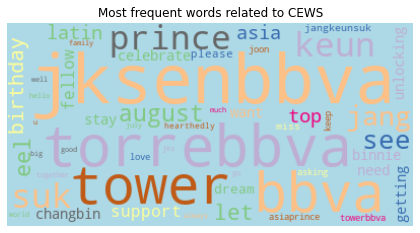

In [24]:
# Visualizing the top 'num_of_words' (by frequency)
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

flat_words = [item for sublist in tweets_details_df['clean'] for item in sublist]
word_freq = FreqDist(flat_words)
most_common_count = [x[1] for x in word_freq.most_common(num_of_words)]
most_common_word = [x[0] for x in word_freq.most_common(num_of_words)]
top_dictionary = dict(zip(most_common_word, most_common_count))

wordcloud = WordCloud(colormap = 'Accent', background_color = 'lightblue').generate_from_frequencies(
    top_dictionary)
plt.figure(facecolor = None)
plt.title('Most frequent words related to CEWS')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

**The above visualization shows the most frequent words in our retrieved Tweets**

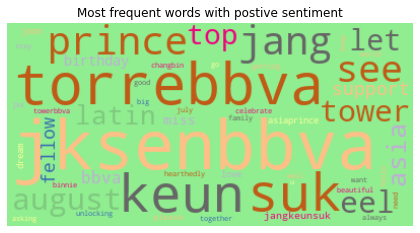

In [25]:
# Visualizing the top 'num_of_words' (by frequency) associated with positive sentiment
flat_words = [item for sublist in analyzed_tweets[analyzed_tweets['nb_classification']=='Positive'].clean for item in sublist]
word_freq = FreqDist(flat_words)
most_common_count = [x[1] for x in word_freq.most_common(num_of_words)]
most_common_word = [x[0] for x in word_freq.most_common(num_of_words)]
top_dictionary = dict(zip(most_common_word, most_common_count))

wordcloud = WordCloud(colormap = 'Accent', background_color = 'lightgreen').generate_from_frequencies(
    top_dictionary)
plt.figure(facecolor = None)
plt.title('Most frequent words with postive sentiment')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

**The above visualization shows the most frequent words associated with positive sentiment Tweets**

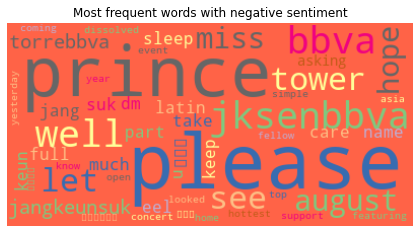

In [26]:
# Visualizing the top 'num_of_words' (by frequency) associated with positive sentiment
flat_words = [item for sublist in analyzed_tweets[analyzed_tweets['nb_classification']=='Negative'].clean for item in sublist]
word_freq = FreqDist(flat_words)
most_common_count = [x[1] for x in word_freq.most_common(num_of_words)]
most_common_word = [x[0] for x in word_freq.most_common(num_of_words)]
top_dictionary = dict(zip(most_common_word, most_common_count))

wordcloud = WordCloud(colormap = 'Accent', background_color = '#FF6347').generate_from_frequencies(
    top_dictionary)
plt.figure(facecolor = None)
plt.title('Most frequent words with negative sentiment')
plt.imshow(wordcloud, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

**The above visualization shows the most frequent words associated with negative sentiment Tweets**

## Future Work

We could segment the tweets using its location to asses the sentiment by province/territory.\
We could group the tweets by date to analyze the sentiment evolution over a time period.\
We could cluster texts by topic (e.g. economy, life-style, politics, etc) and asses the overall sentiment.

# Limitations

Twitter Standard v.2 API allows to retrieve only 450 tweet requests per 15 minute window and retrieved up to 500,000 tweets by month. The tweets retireved can only be up to 7 days old.\
Tweepy Cursor method retrieves tweets from the most current date back to the initial date and fills the total number of tweets that way, therefore, retrieving a small number of tweets will likely only show results from the most recent dates.\
Tweepy only allows to seach tweets by place or keyword but not both.